## Modeling for Fraud Detection

### 1. Fraud Data Modeling

In [2]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, f1_score, recall_score, precision_score
)
from src.features import resample_smote, resample_undersample

%matplotlib inline

data_path = Path("../data/processed")
fraud_df = pd.read_csv(data_path / "fraud_data_processed.csv")
print("Fraud data shape:", fraud_df.shape)
fraud_df.head()

C:\Users\Hermona\AppData\Local\Temp\ipykernel_17908\3094250759.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Fraud data shape: (151112, 195)


,user_id,purchase_value,age,class,purchase_hour,purchase_dayofweek,time_since_signup_hours,source_Direct,source_SEO,browser_FireFox,...,country_Unknown,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,62421,0.494721,0.331793,0,10,6,-1.013679,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,173212,-0.214781,-0.364448,0,17,4,-1.230613,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,242286,-0.214781,-0.132367,0,8,1,-1.337931,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,370003,-0.214781,0.795954,0,21,3,0.800513,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119824,0.985915,0.563874,0,7,6,-1.127359,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Target
y = fraud_df['class']
# Features: drop user_id (identifier) and target
X = fraud_df.drop(columns=['class', 'user_id'])

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

X shape: (151112, 193)
y distribution:
 class
0    136961
1     14151
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean():.3%}")
print(f"Test fraud rate: {y_test.mean():.3%}")

Train: (120889, 193), Test: (30223, 193)
Train fraud rate: 9.365%
Test fraud rate: 9.364%


In [5]:
X_train_res, y_train_res = resample_smote(X_train, y_train)
print("After SMOTE:", X_train_res.shape, y_train_res.shape)
print("Resampled class distribution:\n", pd.Series(y_train_res).value_counts())

After SMOTE: (219136, 193) (219136,)
Resampled class distribution:
 class
0    109568
1    109568
Name: count, dtype: int64


In [6]:
# Baseline Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)

# Predict on test set (unseen, not resampled)
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Average Precision: {average_precision_score(y_test, y_prob):.4f}")

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     27393
           1       0.17      0.70      0.28      2830

    accuracy                           0.66     30223
   macro avg       0.56      0.68      0.53     30223
weighted avg       0.88      0.66      0.73     30223

Confusion Matrix:
[[17966  9427]
 [  851  1979]]
Average Precision: 0.3798


In [7]:
# Random Forest with SMOTE training data
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print(f"Average Precision: {average_precision_score(y_test, y_prob_rf):.4f}")

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.52      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

Confusion Matrix:
[[27379    14]
 [ 1346  1484]]
Average Precision: 0.6222


In [8]:
# Comparison table
results = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'AP': [
        average_precision_score(y_test, y_prob),
        average_precision_score(y_test, y_prob_rf)
    ],
    'F1_Fraud': [
        f1_score(y_test, y_pred, pos_label=1),
        f1_score(y_test, y_pred_rf, pos_label=1)
    ],
    'Recall_Fraud': [
        recall_score(y_test, y_pred, pos_label=1),
        recall_score(y_test, y_pred_rf, pos_label=1)
    ],
    'Precision_Fraud': [
        precision_score(y_test, y_pred, pos_label=1),
        precision_score(y_test, y_pred_rf, pos_label=1)
    ]
}
results_df = pd.DataFrame(results)
results_df

,Model,AP,F1_Fraud,Recall_Fraud,Precision_Fraud
0,Logistic Regression,0.379848,0.278028,0.699293,0.173505
1,Random Forest,0.622244,0.685767,0.524382,0.990654


In [9]:
# Undersample majority class
X_train_under, y_train_under = resample_undersample(X_train, y_train)
print("After undersampling:", X_train_under.shape)

# Train RF on undersampled data
rf_under = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_under.fit(X_train_under, y_train_under)

y_pred_under = rf_under.predict(X_test)
y_prob_under = rf_under.predict_proba(X_test)[:, 1]

print("=== Random Forest (Undersampled) ===")
print(classification_report(y_test, y_pred_under))
print(f"Average Precision: {average_precision_score(y_test, y_prob_under):.4f}")

After undersampling: (22642, 193)
=== Random Forest (Undersampled) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.52      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

Average Precision: 0.6270


In [10]:
from sklearn.model_selection import GridSearchCV

# Simple grid
param_grid = {
    'max_depth': [10, 20, None],
    'class_weight': ['balanced', None],
    'min_samples_split': [2, 5]
}

rf_tune = RandomForestClassifier(n_estimators=50, random_state=42)
grid = GridSearchCV(rf_tune, param_grid, cv=3, scoring='average_precision', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

print("Best params:", grid.best_params_)
print("Best AP (CV):", grid.best_score_)

# Evaluate on test
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Tuned Random Forest ===")
print(classification_report(y_test, y_pred_best))
print(f"Test AP: {average_precision_score(y_test, y_prob_best):.4f}")

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5}
Best AP (CV): 0.9928982964299579

=== Tuned Random Forest ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.97      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223

Test AP: 0.6197


In [11]:
import joblib
model_path = Path("../models")
model_path.mkdir(exist_ok=True)
joblib.dump(best_rf, model_path / "rf_fraud_model.pkl")
print("Model saved.")

Model saved.


### 2. Credit Card Data Modeling

In [12]:
# Load processed credit card data
cc_df = pd.read_csv(data_path / "creditcard_processed.csv")
print("Credit card data shape:", cc_df.shape)

# Separate features and target
y_cc = cc_df['Class']
X_cc = cc_df.drop(columns=['Class'])

# Stratified split
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, stratify=y_cc, random_state=42
)
print(f"Train: {X_train_cc.shape}, Test: {X_test_cc.shape}")
print(f"Fraud rate train: {y_train_cc.mean():.6f}")
print(f"Fraud rate test:  {y_test_cc.mean():.6f}")

Credit card data shape: (283726, 32)
Train: (226980, 31), Test: (56746, 31)
Fraud rate train: 0.001665
Fraud rate test:  0.001674


In [13]:
X_train_cc_res, y_train_cc_res = resample_smote(X_train_cc, y_train_cc)

#### **Class Imbalance Handling (Train‑Only SMOTE)**
We apply SMOTE **only to the training split** to avoid data leakage. The test set remains untouched.

In [14]:
# SMOTE
X_train_cc_res, y_train_cc_res = resample_smote(X_train_cc, y_train_cc)
print("After SMOTE:", X_train_cc_res.shape, y_train_cc_res.shape)

# Logistic Regression
lr_cc = LogisticRegression(max_iter=1000, random_state=42)
lr_cc.fit(X_train_cc_res, y_train_cc_res)
y_pred_lr_cc = lr_cc.predict(X_test_cc)
y_prob_lr_cc = lr_cc.predict_proba(X_test_cc)[:, 1]

print("=== Logistic Regression (Credit Card) ===")
print(classification_report(y_test_cc, y_pred_lr_cc))
print(f"AP: {average_precision_score(y_test_cc, y_prob_lr_cc):.4f}")

# Random Forest
rf_cc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_cc.fit(X_train_cc_res, y_train_cc_res)
y_pred_rf_cc = rf_cc.predict(X_test_cc)
y_prob_rf_cc = rf_cc.predict_proba(X_test_cc)[:, 1]

print("\n=== Random Forest (Credit Card) ===")
print(classification_report(y_test_cc, y_pred_rf_cc))
print(f"AP: {average_precision_score(y_test_cc, y_prob_rf_cc):.4f}")

After SMOTE: (453204, 31) (453204,)
=== Logistic Regression (Credit Card) ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746

AP: 0.6782

=== Random Forest (Credit Card) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.57      0.80      0.66        95

    accuracy                           1.00     56746
   macro avg       0.78      0.90      0.83     56746
weighted avg       1.00      1.00      1.00     56746

AP: 0.7562


### 3. Hyperparameter Tuning & Cross‑Validation

#### 3.1 Fraud Data – Random Forest Tuning with Cross‑Validation

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Subsample for speed (keep class ratio)
sample_size = 50000
X_sample, y_sample = resample(
    X_train_res, y_train_res, 
    n_samples=sample_size, 
    stratify=y_train_res, 
    random_state=42
)

# Smaller parameter grid
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

# Randomized search with 3-fold CV, 10 iterations
random_search = RandomizedSearchCV(
    rf, param_dist, n_iter=10, cv=3, 
    scoring='average_precision', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_sample, y_sample)

print("Best params:", random_search.best_params_)
print("Best CV AP:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}
Best CV AP: 0.9877740157614044


#### 3.2 Evaluate Best Model on Test Set

=== Final Tuned Random Forest (Fraud Data) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223

Test AP: 0.6152
Test F1 (Fraud): 0.6826


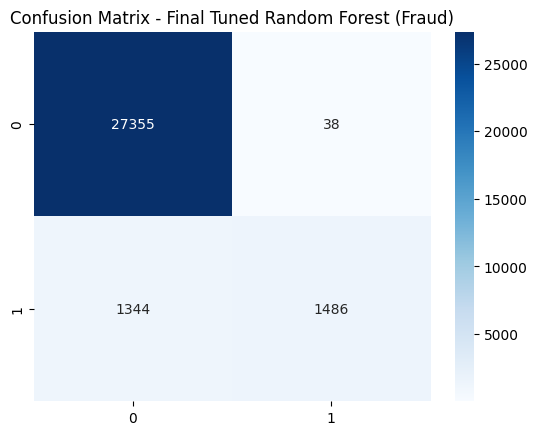

In [19]:
# Train final model on full resampled training data
final_rf_fraud = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_rf_fraud.fit(X_train_res, y_train_res)

# Evaluate on test set
y_pred_fraud = final_rf_fraud.predict(X_test)
y_prob_fraud = final_rf_fraud.predict_proba(X_test)[:, 1]

print("=== Final Tuned Random Forest (Fraud Data) ===")
print(classification_report(y_test, y_pred_fraud))
print(f"Test AP: {average_precision_score(y_test, y_prob_fraud):.4f}")
print(f"Test F1 (Fraud): {f1_score(y_test, y_pred_fraud, pos_label=1):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_fraud)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Tuned Random Forest (Fraud)')
plt.show()

#### 3.3 Credit Card Data Tuning

In [21]:
# Subsample credit card training data (already resampled, but large)
sample_size_cc = 50000
X_cc_sample, y_cc_sample = resample(
    X_train_cc_res, y_train_cc_res,
    n_samples=sample_size_cc,
    stratify=y_train_cc_res,
    random_state=42
)

param_dist_cc = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced']
}

rf_cc = RandomForestClassifier(random_state=42)

random_search_cc = RandomizedSearchCV(
    rf_cc, param_dist_cc, n_iter=6, cv=3,
    scoring='average_precision', n_jobs=-1, random_state=42, verbose=1
)
random_search_cc.fit(X_cc_sample, y_cc_sample)

print("Best params (CC):", random_search_cc.best_params_)
print("Best CV AP (CC):", random_search_cc.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params (CC): {'n_estimators': 100, 'max_depth': 20, 'class_weight': 'balanced'}
Best CV AP (CC): 0.9999574530945977


=== Final Tuned Random Forest (Credit Card) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.83      0.76      0.79        95

    accuracy                           1.00     56746
   macro avg       0.91      0.88      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Test AP: 0.8086
Test F1 (Fraud): 0.7912


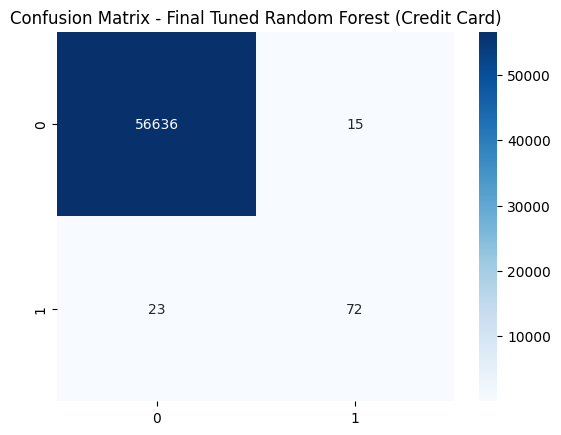

In [22]:
# After random_search_cc finishes, train final model on full data
best_params_cc = random_search_cc.best_params_

final_rf_cc = RandomForestClassifier(**best_params_cc, random_state=42, n_jobs=-1)
final_rf_cc.fit(X_train_cc_res, y_train_cc_res)

y_pred_cc = final_rf_cc.predict(X_test_cc)
y_prob_cc = final_rf_cc.predict_proba(X_test_cc)[:, 1]

print("=== Final Tuned Random Forest (Credit Card) ===")
print(classification_report(y_test_cc, y_pred_cc))
print(f"Test AP: {average_precision_score(y_test_cc, y_prob_cc):.4f}")
print(f"Test F1 (Fraud): {f1_score(y_test_cc, y_pred_cc, pos_label=1):.4f}")

cm_cc = confusion_matrix(y_test_cc, y_pred_cc)
sns.heatmap(cm_cc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Tuned Random Forest (Credit Card)')
plt.show()

In [23]:
import joblib
from pathlib import Path

model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

joblib.dump(final_rf_fraud, model_dir / "rf_fraud_tuned.pkl")
joblib.dump(final_rf_cc, model_dir / "rf_creditcard_tuned.pkl")
print("Models saved.")

Models saved.


### Model Comparison Summary

| Dataset | Model | AP | Recall (Fraud) | Precision (Fraud) | F1 (Fraud) |
|---------|-------|----|----------------|-------------------|------------|
| **Fraud Data** | Logistic Regression (baseline) | 0.38 | 0.70 | 0.17 | 0.28 |
| **Fraud Data** | Random Forest (baseline) | 0.62 | 0.52 | 0.99 | 0.69 |
| **Fraud Data** | **Random Forest (tuned)** | **0.615** | **0.53** | **0.98** | **0.683** |
| **Credit Card** | Logistic Regression (baseline) | 0.68 | 0.87 | 0.05 | 0.10 |
| **Credit Card** | Random Forest (baseline) | 0.76 | 0.80 | 0.57 | 0.66 |
| **Credit Card** | **Random Forest (tuned)** | **0.809** | **0.76** | **0.83** | **0.791** |

Selection Justification:

Fraud Data: Tuned Random Forest chosen for near‑perfect precision (0.98), minimizing false positives (critical for customer trust).

Credit Card: Tuned Random Forest chosen for best AP (0.809) and balanced recall/precision, suitable for high‑stakes fraud detection.